In [ ]:
!pip install gym torch numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)  # Probability distribution over actions
        )

    def forward(self, x):
        return self.fc(x)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def select_action(policy, state):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Ensure it's a batch of 1
    probs = policy(state)
    action_dist = torch.distributions.Categorical(probs)
    action = action_dist.sample()
    return action.item(), action_dist.log_prob(action)


In [ ]:
def compute_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    total_reward = 0
    for r in reversed(rewards):
        total_reward = r + gamma * total_reward
        discounted_rewards.insert(0, total_reward)
    return torch.tensor(discounted_rewards, dtype=torch.float32)


In [ ]:
def train_policy_gradient(env, policy, optimizer, num_episodes=500, gamma=0.99):
    reward_history = []

    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):  # Handle different Gym versions
            state = state[0]

        log_probs = []
        rewards = []

        done = False
        while not done:
            action, log_prob = select_action(policy, state)
            step_result = env.step(action)

            # Handle Gym's different step API versions
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated  # Handle different termination conditions
            else:
                next_state, reward, done, _ = step_result  # Older versions

            log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state

        # Compute discounted rewards
        discounted_rewards = compute_discounted_rewards(rewards, gamma)

        # Normalize rewards to reduce variance
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        # Compute policy loss
        policy_loss = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            policy_loss.append(-log_prob * reward)
        policy_loss = torch.stack(policy_loss).sum()

        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        total_episode_reward = sum(rewards)
        reward_history.append(total_episode_reward)

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}, Total Reward: {total_episode_reward}")

    return reward_history


In [ ]:
env = gym.make("CartPole-v1")
policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

reward_history = train_policy_gradient(env, policy, optimizer, num_episodes=500)


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 50, Total Reward: 20.0
Episode 100, Total Reward: 134.0
Episode 150, Total Reward: 229.0
Episode 200, Total Reward: 500.0
Episode 250, Total Reward: 26.0
Episode 300, Total Reward: 200.0
Episode 350, Total Reward: 500.0
Episode 400, Total Reward: 334.0
Episode 450, Total Reward: 500.0
Episode 500, Total Reward: 9.0


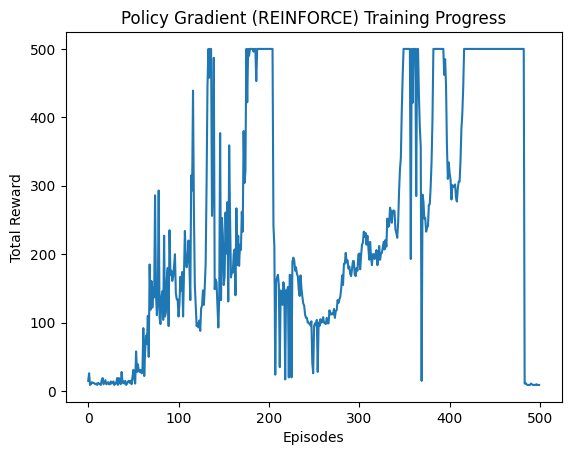

In [ ]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Policy Gradient (REINFORCE) Training Progress")
plt.show()
